# Facial Keypoints Detection

<b> In this notebook, we explore different CNN models. Starting with a simple CNN to testing some architectures inspired from popular ones like LeNet-5, AlexNet, VGG-16. </b>

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
from scipy.ndimage import gaussian_filter
from math import sin,cos,pi
#from skimage import exposure
from matplotlib import pyplot as plt
%matplotlib inline


In [121]:
#from keras.backend.tensorflow_backend import set_session
import sys, os, re, time, warnings
import tensorflow as tf
from tensorflow import keras as keras
from keras import models, callbacks
from keras import Sequential, Model
from keras import optimizers, metrics
from keras.layers import Dense, Dropout, Activation, Flatten, InputLayer
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras import utils
from keras import backend as K
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Concatenate
from keras.layers import Embedding

#tf.test.gpu_device_name()
print("tensorflow version {}".format(tf.__version__))
print("keras version {}".format(keras.__version__))

tensorflow version 1.15.2
keras version 2.2.4-tf


## Dataset

- The input images are 96x96 pixels represented in (0,255)
- The following 15 keypoints, represnted in (x,y), should be predicted:

  left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

- 7049 training images and 1783 testing images 

### Load the Datasets


In [3]:
# train and test datasets file paths
FTRAIN = '../data/training/training.csv'
FTEST = '../data/test/test.csv'

In [55]:
# Predict on kaggle test data
FLOOKUP = '../data/IdLookupTable.csv'

In [95]:
# Function to load the dataset into numpy arrays
def load_dataset(test = False, drop_bad_data = True):
    
    filename = FTEST if test else FTRAIN
    
    print("Loading Data...")
    
    # Read the data into a pandas dataframe
    df = pd.read_csv(os.path.expanduser(filename))

    # 'Image' column has pixel values for input images separated by space which will be 
    # converted to numpy arrays
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if not test:
        # Apply only on train data
        
        # Drop any bad data
        if drop_bad_data:
            bad_image_indices = [1747, 1877, 1907, 2199]
            cnt = 0
            for index in bad_image_indices:
                df = df.drop(df.index[index - 1 - cnt])
                cnt += 1
            # Drop rows with missing data
            df = df.dropna()
            
    # Scale the pixel values to be between 0, 1
    #X = np.vstack(df['Image'].values) / 255.
    X = np.vstack(df['Image'].values)
    X = X.astype(np.float32)
    #X = X.reshape(-1, 96, 96, 1)
    
    if not test:
        # Apply only on train data
        
        # Extract the labels(x, y coordinates of facial key points) from train data
        y = df[df.columns[:-1]].values
    
        # data with missing labels will be removed from train data
        X = X[~ np.isnan(y).any(axis=1)]
        y = y[~ np.isnan(y).any(axis=1)]
        
        # Scale the labels which are x,y coordinates of the facial key points to be between -1 and 1
        #y = (y - 48) / 48
        y = y.astype(np.float32)
        
      
    else:
        y = None
        
    # Reshape the images
    X = X.reshape(-1, 96, 96, 1)

    if not test:
        # Shuffle the data
        X, y = shuffle(X, y, random_state=42)

    # Return the train/test data and labels(only for train data)
    return X, y

# function to split given kaggle train data into train and dev datasets for further work
def split_data(X, y):
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    return  X_train, X_dev, Y_train, Y_dev

# function to plot an image
def plot_image(x, y, axis):
    # Reshape input into a matrix of pixels
    img = x.reshape(96, 96)
    
    # Plot the pixels on gray scale
    axis.imshow(img, cmap = 'gray')
    
    # Mark the x and y co-ordinates with 'x' in red color
    
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=20, c='red')
    
# function to plot an image with train and predicted keypoints
def plot_predict(x, y, y_predict, axis):
    # Reshape input into a matrix of pixels
    img = x.reshape(96, 96)
    
    # Plot the pixels on gray scale
    axis.imshow(img, cmap = 'gray')
    
    # Mark the x and y co-ordinates with 'x' in red color
    
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2], y[1::2], marker='o', s=20, c='red')
    axis.scatter(y_predict[0::2], y_predict[1::2], marker='o', s=20, c='yellow')
    
# function to get original kaggle train data
def get_orig_train_data():
    
    # Get the location of the train dataset
    fname = FTRAIN
    
    print("Loading data...")
    
    # Read data into pandas dataframe
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # 'Image' column has pixel values for input images separated by space which will be 
    # converted to numpy arrays 
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    # Scale the pixel values to be between 0, 1
    X = np.vstack(df['Image'].values) / 255.  
    X = X.astype(np.float32)
    
    # Extract the labels(x, y coordinates of facial key points) from train data
    y = df[df.columns[:-1]].values
    
    # Scale the labels which are x,y coordinates of the facial key points to be between -1 and 1
    y = (y - 48) / 48  # scale target coordinates to [-1, 1]
    y = y.astype(np.float32)
    
    # Reshape the images
    X = X.reshape(-1, 1, 96, 96)

    return X, y  

# Function to plot predictions and generate kaggle submission file
def plot_generate_submission_file(model, model_name):
    
    # Load the test dataset
    print("Loading dataset..")
    #train = pd.read_csv(os.path.expanduser(FTRAIN))
    test = pd.read_csv(os.path.expanduser(FTEST))
    # Load the lookup file
    lookup = pd.read_csv(os.path.expanduser(FLOOKUP))
    
    # split out image values
    image = []
    for i in range(test.shape[0]):
        img = test['Image'][i].split(' ')
        img = ['0' if j == '' else j for j in img]
        image.append(img)
    
    # Reshape for prediction
    X_test = np.array(image, dtype = 'float').reshape(-1,96,96,1)
    X_test.shape
    
    # predict on test data
    Y_test = model.predict(X_test)
    
    # Plot - Have to correct this
    #fig = plt.figure(figsize=(20, 20))
    #fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    #for i in range(16):
        #ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        #img = X_test[i].reshape(96, 96)
        #ax.imshow(img, cmap='gray')
        #ax.scatter(Y_test[0::2], Y_test[1::2], marker='o', color = 'red', s=50, label = 'predict')
        
    #plt.show()
    
    # Generate submission file
    submission0 = pd.DataFrame(Y_test, columns=train.columns[:-1])
    submission1 = pd.concat([test['ImageId'], submission0], axis=1)
    submission2 = pd.melt(submission1, id_vars=['ImageId'], value_vars=train.columns[:-1]).rename \
        (columns={"variable": "FeatureName", "value": "Location"})
    submission3 = pd.merge(lookup.drop(columns=['Location']), submission2, on=['ImageId','FeatureName'], how='left')
    submission_final = submission3[['RowId', 'Location']]

    print(submission_final.shape)
    submission_final.head()
    # Save the file
    submission_final.to_csv(model_name+'.csv', index=False)

Loading data...


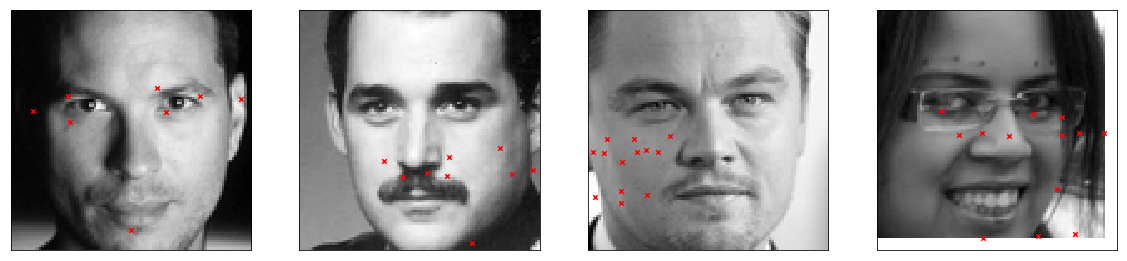

In [8]:
# function to show the images with bad labels for the facial keypoints
def plt_bad_data():
    # indices of the bad data(obtained by manual scan of the dataset)
    image_indices = [1747, 1877, 1907, 2199]
    
    # Read the train data from kaggle dataset
    X,y = get_orig_train_data()
    
    # Set the plot dimensions
    fig = plt.figure(figsize=(25,25))
    # Plot the bad images with facial keypoints
    for i in range(len(image_indices)):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        
        # Call function to plot the image and keypoints
        plot_image(X[image_indices[i]][0:1],y[image_indices[i]], ax)
        
    plt.show()

# Plot the train data images with bad labels for the facial keypoints
plt_bad_data()

In [70]:
# Load the pre-processed train data 
train_data, train_labels = load_dataset(test = False)
print("Train Images: " + str(train_data.shape) + " Train Labels: " + str(train_labels.shape))

Loading Data...
Train Images: (2137, 96, 96, 1) Train Labels: (2137, 30)


In [71]:
# Split pre-processed train data into train and dev data with 80:20 split
X_train, X_dev, Y_train, Y_dev = train_test_split(train_data, train_labels)
print("X_Train: " + str(X_train.shape) + " Y_Train: " + str(Y_train.shape))
print("X_Dev: " + str(X_dev.shape) + " Y_dev: " + str(Y_dev.shape))


X_Train: (1602, 96, 96, 1) Y_Train: (1602, 30)
X_Dev: (535, 96, 96, 1) Y_dev: (535, 30)


In [14]:
print(len(X_train))

1602


In [15]:
X_train_orig, Y_train_orig = X_train, Y_train

## Modeling

### Baseline

#### Single layer CNN with 10 filters and 13 epochs. Activation: relu Optimization: adam

In [185]:
# Single Layer CNN

# create baseline CNN model with 1 convoluted layer with relu activation
# input is 96X96 pixel images with 1 channel(gray scale) -> (96, 96, 1) tensors
# applies 10 convolution filters of 3X3 each
model = Sequential()
model.add(Conv2D(10, (3, 3), activation='relu', input_shape=(96,96,1), data_format='channels_last'))
model.add(Flatten())
model.add(Dense(30))

# Helper function to find RMSE(Root Mean Squared Error)
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# compile model for the learning process
# 'adam' optimizer is used
model.compile(loss=rmse, optimizer='adam', metrics=[rmse])

# fit model with 13 epochs(best after trials) and batch size = 32 and using dev dataset as validation set
%time history_cnn_base = model.fit(X_train, Y_train, epochs=13, shuffle=True, batch_size=32, \
                                   validation_split = 0, validation_data=(X_dev, Y_dev), verbose=2)

# Summary of trained model
model.summary()

Train on 1602 samples, validate on 535 samples
Epoch 1/13
 - 4s - loss: 122.8347 - rmse: 122.8347 - val_loss: 16.3642 - val_rmse: 16.3642
Epoch 2/13
 - 3s - loss: 11.6519 - rmse: 11.6519 - val_loss: 14.1101 - val_rmse: 14.1101
Epoch 3/13
 - 3s - loss: 9.8601 - rmse: 9.8601 - val_loss: 9.6786 - val_rmse: 9.6786
Epoch 4/13
 - 3s - loss: 7.7774 - rmse: 7.7774 - val_loss: 9.5856 - val_rmse: 9.5856
Epoch 5/13
 - 3s - loss: 6.2578 - rmse: 6.2578 - val_loss: 9.5868 - val_rmse: 9.5868
Epoch 6/13
 - 3s - loss: 6.3747 - rmse: 6.3747 - val_loss: 9.3363 - val_rmse: 9.3363
Epoch 7/13
 - 3s - loss: 6.4225 - rmse: 6.4225 - val_loss: 9.5176 - val_rmse: 9.5176
Epoch 8/13
 - 3s - loss: 6.4461 - rmse: 6.4461 - val_loss: 9.3293 - val_rmse: 9.3293
Epoch 9/13
 - 3s - loss: 5.6225 - rmse: 5.6225 - val_loss: 11.0108 - val_rmse: 11.0108
Epoch 10/13
 - 3s - loss: 5.5698 - rmse: 5.5698 - val_loss: 9.3005 - val_rmse: 9.3005
Epoch 11/13
 - 3s - loss: 5.6463 - rmse: 5.6463 - val_loss: 9.1779 - val_rmse: 9.1779
Epoc

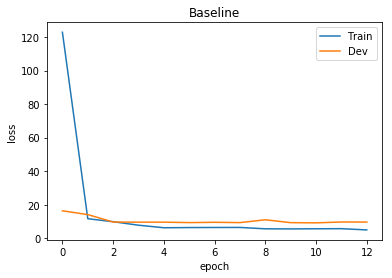

In [186]:
# plot metrics
plt.plot(history_cnn_base.history['rmse'], label = 'Train')
plt.plot(history_cnn_base.history['val_rmse'], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Baseline')
plt.show()

In [187]:
# look at final RMSE value after 13 epochs
print(history_cnn_base.history.get('val_rmse')[-1])
print(history_cnn_base.history.get('rmse')[-1])

9.648152716806003
4.968868125244026


In [188]:
plot_generate_submission_file(model, 'baseline_2')

Loading dataset..
(27124, 2)


### Model 1

#### Single layer CNN with 16 filters and 13 epochs. Activation: relu Optimization: adam

In [27]:
# The early stop callback will terminate a training session if no progress is being made
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=100, mode='auto')

In [28]:
# Model 1 Single Layer CNN with 16 filters

# create baseline CNN model with 1 convoluted layer with relu activation
# input is 96X96 pixel images with 1 channel(gray scale) -> (96, 96, 1) tensors
# applies 10 convolution filters of 3X3 each
model = Sequential()
model.add(Conv2D(10, (3, 3), activation='relu', input_shape=(96,96,1), data_format='channels_last'))
model.add(Flatten())
model.add(Dense(30))

# compile model for the learning process
# 'adam' optimizer is used
model.compile(loss=rmse, optimizer='adam', metrics=[rmse])

# fit model with 13 epochs(best after trials) and batch size = 32 and using dev dataset as validation set
%time history_cnn_m1 = model.fit(X_train, Y_train, epochs=13, shuffle=True, \
                                 batch_size=32, validation_split = 0, validation_data=(X_dev, Y_dev), \
                                 callbacks=[early_stop], verbose=2)

# Summary of trained model
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)


Train on 1602 samples, validate on 535 samples
Epoch 1/13
1602/1602 - 3s - loss: 247.8827 - rmse: 244.1693 - val_loss: 51.4689 - val_rmse: 51.4095
Epoch 2/13
1602/1602 - 3s - loss: 38.1985 - rmse: 37.9786 - val_loss: 30.9826 - val_rmse: 30.9730
Epoch 3/13
1602/1602 - 3s - loss: 30.0697 - rmse: 30.0912 - val_loss: 31.8142 - val_rmse: 31.7807
Epoch 4/13
1602/1602 - 3s - loss: 25.1850 - rmse: 25.2883 - val_loss: 27.0215 - val_rmse: 27.0310
Epoch 5/13
1602/1602 - 3s - loss: 19.7257 - rmse: 19.5466 - val_loss: 23.1216 - val_rmse: 23.1019
Epoch 6/13
1602/1602 - 3s - loss: 13.6113 - rmse: 13.5213 - val_loss: 17.6255 - val_rmse: 17.6284
Epoch 7/13
1602/1602 - 3s - loss: 10.7752 - rmse: 10.7762 - val_loss: 12.9397 - val_rmse: 12.9707
Epoch 8/13
1602/1602 - 3s - loss: 7.9811 - rmse: 7.9621 - val_loss: 10.9016 - val_rmse: 10.9392
Epoch 9/13
1602/1602 - 3s - loss: 7.8308 - rmse: 7.7957 - val_loss: 11.6022 - val_rmse: 11.5895
Epoch 10/13
1602/1602 - 3s - loss: 7.4988 - rmse: 7.4571 - val_loss: 10.1

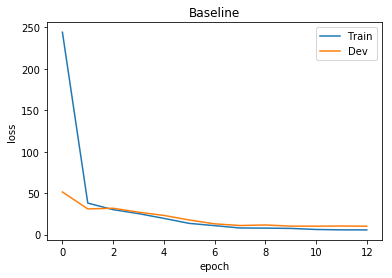

In [31]:
# plot metrics
plt.plot(history_cnn_m1.history['rmse'], label = 'Train')
plt.plot(history_cnn_m1.history['val_rmse'], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Baseline')
plt.show()

In [32]:
# look at final RMSE value after 13 epochs
print(history_cnn_m1.history.get('val_rmse')[-1])
print(history_cnn_m1.history.get('rmse')[-1])

10.059102
5.6245556


### Model 2: LeNet-5 Inspired

TO DO: try to change optimizer to 'SGD' etc, batch size upto 128

In [82]:
# Try to create a LeNet-5 based model using 'relu' activation 

# create model 
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(96,96,1), data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1), padding='valid'))
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding='valid'))
model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(30))

# compile model
model.compile(loss=rmse, optimizer='adam', metrics=[rmse])

# fit model
%time history_m2 = model.fit(X_train, Y_train, epochs=10, shuffle=True, batch_size=5, \
                             validation_split = 0, validation_data=(X_dev, Y_dev), \
                             callbacks=[early_stop], verbose=2)

# Summary of trained model
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Train on 1602 samples, validate on 535 samples
Epoch 1/10
1602/1602 - 53s - loss: 17.0164 - rmse: 16.9912 - val_loss: 8.8370 - val_rmse: 8.8370
Epoch 2/10
1602/1602 - 53s - loss: 8.4499 - rmse: 8.4436 - val_loss: 9.0674 - val_rmse: 9.0674
Epoch 3/10
1602/1602 - 53s - loss: 7.3567 - rmse: 7.3496 - val_loss: 7.3034 - val_rmse: 7.3034
Epoch 4/10
1602/1602 - 53s - loss: 6.5886 - rmse: 6.6016 - val_loss: 8.8217 - val_rmse: 8.8217
Epoch 5/10
1602/1602 - 53s - loss: 7.1247 - rmse: 7.1250 - val_loss: 9.6565 - val_rmse: 9.6565
Epoch 6/10
1602/1602 - 53s - loss: 6.2991 - rmse: 6.2928 - val_loss: 6.6759 - val_rmse: 6.6759
Epoch 7/10
1602/1602 - 53s - loss: 5.3775 - rmse: 5.3730 - val_loss: 13.0253 - val_rmse: 13.0253
Epoch 8/10
1602/1602 - 53s - loss: 4.9959 - rmse: 5.0003 - val_loss: 5.1581 - val_rmse: 5.1581
Epoch 9/10
1602/1602 - 52s - loss: 4.1532 - rmse: 4.1528 - val_loss: 4.0427 - val_rmse: 4.0427
Epoch 10/10
1602/1602 - 53s - loss: 3.0088 - rmse: 3.0066 - val_loss: 3.1490 - val_rmse: 3.149

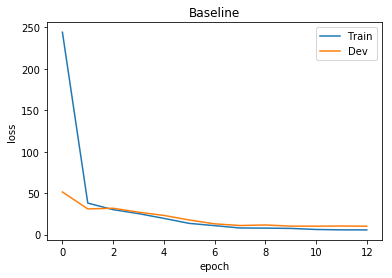

In [83]:
# plot metrics
plt.plot(history_cnn_m1.history['rmse'], label = 'Train')
plt.plot(history_cnn_m1.history['val_rmse'], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Baseline')
plt.show()

In [84]:
model.save('model2_lenet.h5')

In [85]:
# look at final RMSE value after 10 epochs
print(history_m2.history.get('val_rmse')[-1])
print(history_m2.history.get('rmse')[-1])


3.148993
3.006643


In [86]:
# Predict on dev data
dev_predict = model.predict(X_dev)

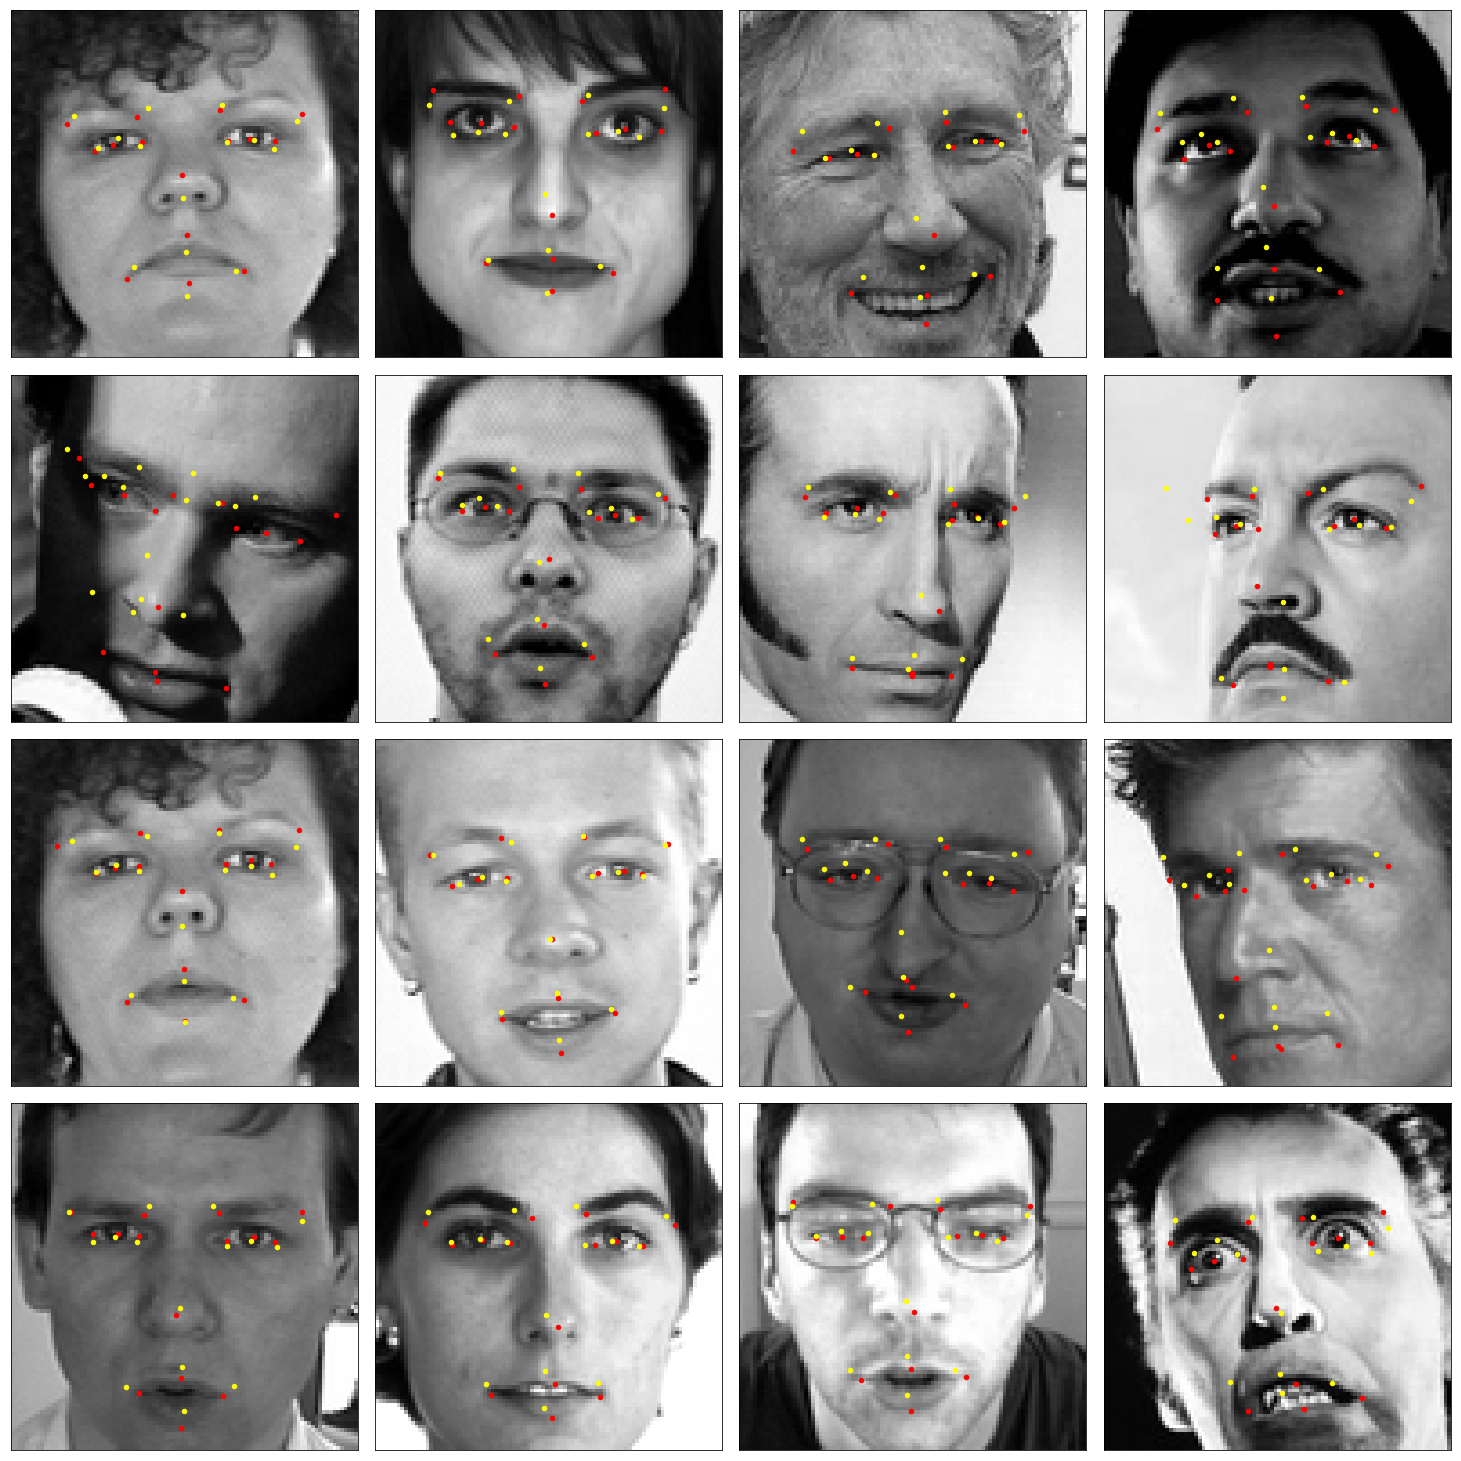

In [87]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_predict(X_dev[i], Y_dev[i], dev_predict[i], ax)

plt.show()

In [3]:
#plot_generate_submission_file(model, 'model2_lenet')

In [ ]:
## Lenet 5 - with 50 epochs 

In [189]:
# Try to create a LeNet-5 based model using 'relu' activation 

# create model 
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(96,96,1), data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1), padding='valid'))
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding='valid'))
model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(30))

# compile model
model.compile(loss=rmse, optimizer='adam', metrics=[rmse])

# fit model
%time history_m2_1 = model.fit(X_train, Y_train, epochs=50, shuffle=True, batch_size=5, \
                             validation_split = 0, validation_data=(X_dev, Y_dev), \
                             callbacks=[early_stop], verbose=2)

# Summary of trained model
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True)

Train on 1602 samples, validate on 535 samples
Epoch 1/50
 - 105s - loss: 14.5978 - rmse: 14.5978 - val_loss: 10.6980 - val_rmse: 10.6980
Epoch 2/50
 - 104s - loss: 9.3177 - rmse: 9.3177 - val_loss: 8.3170 - val_rmse: 8.3170
Epoch 3/50
 - 104s - loss: 8.1231 - rmse: 8.1231 - val_loss: 7.0474 - val_rmse: 7.0474
Epoch 4/50
 - 105s - loss: 7.1278 - rmse: 7.1278 - val_loss: 6.5980 - val_rmse: 6.5980
Epoch 5/50
 - 104s - loss: 6.4308 - rmse: 6.4308 - val_loss: 6.1013 - val_rmse: 6.1013
Epoch 6/50
 - 104s - loss: 5.6841 - rmse: 5.6841 - val_loss: 6.3634 - val_rmse: 6.3634
Epoch 7/50
 - 105s - loss: 5.1318 - rmse: 5.1318 - val_loss: 5.7087 - val_rmse: 5.7087
Epoch 8/50
 - 104s - loss: 4.0851 - rmse: 4.0851 - val_loss: 4.5455 - val_rmse: 4.5455
Epoch 9/50
 - 105s - loss: 3.4628 - rmse: 3.4628 - val_loss: 3.4460 - val_rmse: 3.4460
Epoch 10/50
 - 103s - loss: 2.6577 - rmse: 2.6577 - val_loss: 2.6688 - val_rmse: 2.6688
Epoch 11/50
 - 105s - loss: 2.2065 - rmse: 2.2065 - val_loss: 2.4799 - val_rms

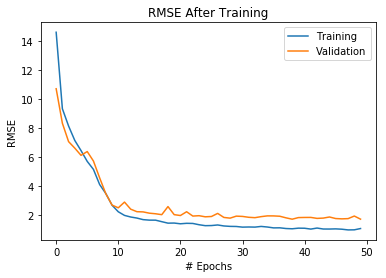

In [190]:
# plot metrics
plt.plot(history_m2_1.history['rmse'], label='Training')
plt.plot(history_m2_1.history['val_rmse'], label='Validation')
plt.xlabel("# Epochs")
plt.ylabel("RMSE")
plt.title('RMSE After Training')
plt.legend()
plt.show()

In [191]:
# look at final RMSE value after 10 epochs
print(history_m2_1.history.get('val_rmse')[-1])
print(history_m2_1.history.get('rmse')[-1])

1.6968384156717318
1.0493879715601604


In [192]:
model.save('model2_1_lenet_epochs_50.h5')

In [193]:
plot_generate_submission_file(model, 'model2_lenet_epochs_50')

Loading dataset..
(27124, 2)


### Model 3: AlexNet Inspired

TO DO: try to change optimizer to 'SGD' etc, batch size upto 128

In [89]:
# define model
def AlexNet2(weights_path=None):
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(96, 96, 1), data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    model.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    model.add(Conv2D(384, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    model.add(Conv2D(384, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2000, activation='relu'))
    model.add(Dense(30))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [90]:
# compile model
model = AlexNet2()
model.compile(loss=rmse, optimizer='adam', metrics=[rmse])

# fit model
%time history_cnn_m3_3 = model.fit(X_train, Y_train, epochs=50, shuffle=True, batch_size=5, \
                             validation_split = 0, validation_data=(X_dev, Y_dev), \
                             callbacks=[early_stop], verbose=2)



Train on 1602 samples, validate on 535 samples
Epoch 1/50
1602/1602 - 28s - loss: 21.3845 - rmse: 21.3679 - val_loss: 8.6001 - val_rmse: 8.6001
Epoch 2/50
1602/1602 - 28s - loss: 7.7703 - rmse: 7.7703 - val_loss: 3.4734 - val_rmse: 3.4734
Epoch 3/50
1602/1602 - 28s - loss: 5.4850 - rmse: 5.4843 - val_loss: 3.1359 - val_rmse: 3.1359
Epoch 4/50
1602/1602 - 28s - loss: 3.9747 - rmse: 3.9730 - val_loss: 3.4492 - val_rmse: 3.4492
Epoch 5/50
1602/1602 - 29s - loss: 3.7212 - rmse: 3.7223 - val_loss: 3.2464 - val_rmse: 3.2464
Epoch 6/50
1602/1602 - 27s - loss: 3.7023 - rmse: 3.7022 - val_loss: 3.2105 - val_rmse: 3.2105
Epoch 7/50
1602/1602 - 27s - loss: 3.6689 - rmse: 3.6668 - val_loss: 3.3375 - val_rmse: 3.3375
Epoch 8/50
1602/1602 - 27s - loss: 3.6964 - rmse: 3.6941 - val_loss: 3.1494 - val_rmse: 3.1494
Epoch 9/50
1602/1602 - 27s - loss: 3.6529 - rmse: 3.6552 - val_loss: 3.3789 - val_rmse: 3.3789
Epoch 10/50
1602/1602 - 28s - loss: 3.6599 - rmse: 3.6651 - val_loss: 3.2923 - val_rmse: 3.2923


In [91]:
# Summary of trained model
model.summary                                                                                    
plot_model(model, show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [92]:
model.save('model3_3_alexnet_epoch_50.h5')

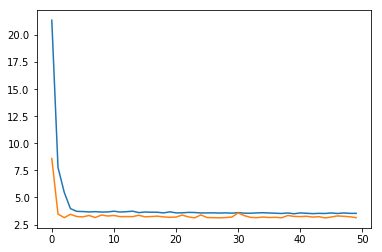

In [93]:
# plot metrics
plt.plot(history_cnn_m3_3.history['rmse'])
plt.plot(history_cnn_m3_3.history['val_rmse'])
plt.show()

In [94]:
# look at final RMSE value after 50 epochs
print(history_cnn_m3_3.history.get('val_rmse')[-1])
print(history_cnn_m3_3.history.get('rmse')[-1])

3.1391664
3.5342073


In [96]:
plot_generate_submission_file(model, 'model3_3_alexnet')

Loading dataset..
(27124, 2)


### Model 4: VGG-16

In [78]:
# VGG-16
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(96,96,1), data_format='channels_last'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(30))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [80]:
# compile model
model = VGG_16()
model.compile(loss=rmse, optimizer='adam', metrics=[rmse])

# fit model
%time history_cnn_m4 = model.fit(X_train, Y_train, epochs=10, shuffle=True, batch_size=5, \
                                 validation_split = 0, validation_data=(X_dev, Y_dev), \
                                 callbacks=[early_stop], verbose=2)

Train on 1602 samples, validate on 534 samples
Epoch 1/10
1602/1602 - 417s - loss: 14.1830 - rmse: 14.1621 - val_loss: 3.7124 - val_rmse: 3.7113
Epoch 2/10
1602/1602 - 415s - loss: 5.9035 - rmse: 5.8999 - val_loss: 3.8559 - val_rmse: 3.8570
Epoch 3/10
1602/1602 - 415s - loss: 5.5190 - rmse: 5.5215 - val_loss: 4.4475 - val_rmse: 4.4493
Epoch 4/10
1602/1602 - 414s - loss: 5.4467 - rmse: 5.4451 - val_loss: 4.1385 - val_rmse: 4.1377
Epoch 5/10
1602/1602 - 416s - loss: 4.9871 - rmse: 4.9825 - val_loss: 5.8640 - val_rmse: 5.8641
Epoch 6/10
1602/1602 - 414s - loss: 4.5917 - rmse: 4.5885 - val_loss: 3.7746 - val_rmse: 3.7739
Epoch 7/10
1602/1602 - 414s - loss: 4.4978 - rmse: 4.4999 - val_loss: 4.3930 - val_rmse: 4.3960
Epoch 8/10
1602/1602 - 415s - loss: 4.4798 - rmse: 4.4803 - val_loss: 3.4005 - val_rmse: 3.4007
Epoch 9/10
1602/1602 - 414s - loss: 4.3639 - rmse: 4.3604 - val_loss: 4.1083 - val_rmse: 4.1082
Epoch 10/10
1602/1602 - 414s - loss: 4.4522 - rmse: 4.4497 - val_loss: 4.0366 - val_rms

In [81]:
model.save('model4_vgg16_epoch_10.h5')

In [82]:
# Summary of trained model
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_13 (ZeroPaddi (None, 98, 98, 1)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 96, 96, 64)        640       
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 48, 48, 128)      

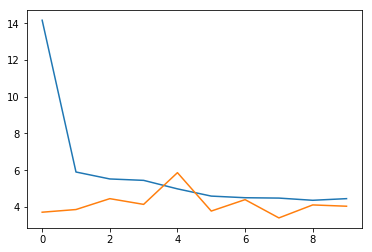

In [83]:
# plot metrics
plt.plot(history_cnn_m4.history['rmse'])
plt.plot(history_cnn_m4.history['val_rmse'])
plt.show()

In [84]:
# look at final RMSE value after 10 epochs
print(history_cnn_m4.history.get('val_rmse')[-1])
print(history_cnn_m4.history.get('rmse')[-1])

4.037111
4.449697


In [195]:
### VGG 2 with smaller filters
def VGG_16_2(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(96,96,1), data_format='channels_last'))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(30))

    if weights_path:
        model.load_weights(weights_path)

    return model

##### VGG-16 with smaller filters

In [196]:
# compile model
model = VGG_16_2()
model.compile(loss=rmse, optimizer='adam', metrics=[rmse])

# fit model
%time history_cnn_m4_2 = model.fit(X_train, Y_train, epochs=50, shuffle=True, batch_size=5, \
                                 validation_split = 0, validation_data=(X_dev, Y_dev), \
                                 callbacks=[early_stop], verbose=2)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 1602 samples, validate on 535 samples
Epoch 1/50
 - 57s - loss: 13.8614 - rmse: 13.8614 - val_loss: 5.1570 - val_rmse: 5.1570
Epoch 2/50
 - 55s - loss: 7.3293 - rmse: 7.3293 - val_loss: 3.5044 - val_rmse: 3.5044
Epoch 3/50
 - 55s - loss: 6.6098 - rmse: 6.6098 - val_loss: 3.1148 - val_rmse: 3.1148
Epoch 4/50
 - 55s - loss: 6.3866 - rmse: 6.3866 - val_loss: 4.7764 - val_rmse: 4.7764
Epoch 5/50
 - 55s - loss: 6.3860 - rmse: 6.3860 - val_loss: 3.1950 - val_rmse: 3.1950
Epoch 6/50
 - 55s - loss: 5.7211 - rmse: 5.7211 - val_loss: 3.5891 - val_rmse: 3.5891
Epoch 7/50
 - 54s - loss: 5.4982 - rmse: 5.4982 - val_loss: 3.2047 - val_rmse: 3.2047
Epoch 8/50
 - 54s - loss: 5.2549 - rmse: 5.2549 - val_loss: 3.1714 - val_rmse: 3.1714
Epoch 9/50
 - 55s - loss: 5.0820 - rmse: 5.0820 - val_loss: 3.1386 - val_rmse: 3.1386
Epoch 10/50
 - 56s - loss: 4.8736 - rmse: 4.8736 - val_loss: 

In [197]:
model.save('model4_vgg16_2_epochs_50.h5')

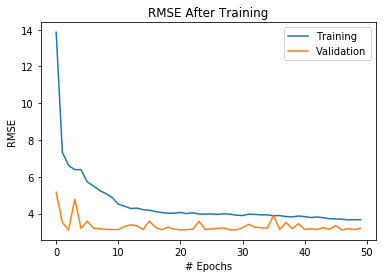

In [198]:
# plot metrics
plt.plot(history_cnn_m4_2.history['rmse'], label='Training')
plt.plot(history_cnn_m4_2.history['val_rmse'], label='Validation')
plt.xlabel("# Epochs")
plt.ylabel("RMSE")
plt.title('RMSE After Training')
plt.legend()
plt.show()

In [199]:
# look at final RMSE value after 50 epochs
print(history_cnn_m4_2.history.get('val_rmse')[-1])
print(history_cnn_m4_2.history.get('rmse')[-1])

3.1921447927706708
3.6596188412772284


In [200]:
plot_generate_submission_file(model, 'model4_2_vgg16')

Loading dataset..
(27124, 2)


### VGG16 Transfer Learning

In [161]:
vgg_base = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))

vgg_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [162]:
# Configure the Fully Connected layers 
class VGG16FCHeadNet:
    @staticmethod
    def build(vgg_base):
        np.random.seed(533)
        # Initialize head model from pre-trained model output
        # 2 FC layers
        headModel = vgg_base.output
        # Add 2 FC layers
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(256, activation="relu")(headModel)
        headModel = Dense(30, activation="linear")(headModel)
        
        return headModel      

In [163]:
# Initialize a new head for the new VGG16 model with customized fully connected layers
head_vgg16 = VGG16FCHeadNet.build(vgg_base)

# Create Frankenstein (attach new FC head to VGG16 body)
vgg16_tf_model = Model(inputs=vgg_base.input, outputs=head_vgg16)

In [164]:
vgg16_tf_model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [165]:
# Freeze the weights
for layer in vgg_base.layers:
    layer.trainable = False

In [168]:
for l in vgg16_tf_model.layers:
    print (l.input_shape)

(None, 96, 96, 3)
(None, 96, 96, 3)
(None, 96, 96, 64)
(None, 96, 96, 64)
(None, 48, 48, 64)
(None, 48, 48, 128)
(None, 48, 48, 128)
(None, 24, 24, 128)
(None, 24, 24, 256)
(None, 24, 24, 256)
(None, 24, 24, 256)
(None, 12, 12, 256)
(None, 12, 12, 512)
(None, 12, 12, 512)
(None, 12, 12, 512)
(None, 6, 6, 512)
(None, 6, 6, 512)
(None, 6, 6, 512)
(None, 6, 6, 512)
(None, 3, 3, 512)
(None, 4608)
(None, 256)


In [166]:
# VGG-16 takes 3 channels as input
X_train_vgg, X_dev_vgg = np.tile(X_train[:,:,:], [1, 1, 3]), np.tile(X_dev[:, :, :], [1, 1, 3])
print(X_train_vgg[0].shape, X_dev_vgg[0].shape)

(96, 96, 3) (96, 96, 3)


In [169]:
#opt = adam(lr=0.001)
vgg16_tf_model.compile(loss = rmse, optimizer = 'adam', metrics = [rmse])

# fit model
%time history_cnn_m5 = vgg16_tf_model.fit(X_train_vgg, Y_train, epochs=10, shuffle=True, batch_size=64, \
                                 validation_split = 0, validation_data=(X_dev_vgg, Y_dev), \
                                 callbacks=[early_stop], verbose=2)



Train on 1602 samples, validate on 535 samples
Epoch 1/10
 - 97s - loss: 17.8265 - rmse: 17.8265 - val_loss: 10.8583 - val_rmse: 10.8583
Epoch 2/10
 - 98s - loss: 8.7169 - rmse: 8.7169 - val_loss: 8.6464 - val_rmse: 8.6464
Epoch 3/10
 - 96s - loss: 6.9965 - rmse: 6.9965 - val_loss: 8.0817 - val_rmse: 8.0817
Epoch 4/10
 - 97s - loss: 6.1795 - rmse: 6.1795 - val_loss: 7.5920 - val_rmse: 7.5920
Epoch 5/10
 - 97s - loss: 5.5784 - rmse: 5.5784 - val_loss: 7.4896 - val_rmse: 7.4896
Epoch 6/10
 - 98s - loss: 5.2394 - rmse: 5.2394 - val_loss: 7.1331 - val_rmse: 7.1331
Epoch 7/10
 - 98s - loss: 4.7913 - rmse: 4.7913 - val_loss: 7.0472 - val_rmse: 7.0472
Epoch 8/10
 - 96s - loss: 4.4744 - rmse: 4.4744 - val_loss: 7.3474 - val_rmse: 7.3474
Epoch 9/10
 - 98s - loss: 4.3757 - rmse: 4.3757 - val_loss: 7.0085 - val_rmse: 7.0085
Epoch 10/10
 - 97s - loss: 4.0077 - rmse: 4.0077 - val_loss: 6.7224 - val_rmse: 6.7224
CPU times: user 1h 1min 42s, sys: 2min 1s, total: 1h 3min 43s
Wall time: 16min 10s


In [170]:
vgg16_tf_model.save('model5_vgg16_tf_epoch_10.h5')

In [171]:
# look at final RMSE value after 10 epochs
print(history_cnn_m5.history.get('val_rmse')[-1])
print(history_cnn_m5.history.get('rmse')[-1])

6.7224287024168214
4.007666065154153


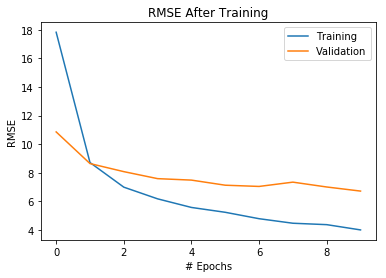

In [174]:
# plot metrics
plt.plot(history_cnn_m5.history['rmse'], label='Training')
plt.plot(history_cnn_m5.history['val_rmse'], label='Validation')
plt.xlabel("# Epochs")
plt.ylabel("RMSE")
plt.title('RMSE After Training')
plt.legend()
plt.show()

In [180]:
# Now that the fully connected layers are warmed up, we can try to unfreeze the final set of Convoluted layers
for layer in vgg_base.layers[-5:]:
    layer.trainable = True

In [181]:
# Run the model again
vgg16_tf_model.compile(loss = rmse, optimizer = 'adam', metrics = [rmse])

# fit model
%time history_cnn_m6 = vgg16_tf_model.fit(X_train_vgg, Y_train, epochs=15, shuffle=True, batch_size=64, \
                                 validation_split = 0, validation_data=(X_dev_vgg, Y_dev), \
                                 callbacks=[early_stop], verbose=2)

Train on 1602 samples, validate on 535 samples
Epoch 1/15
 - 119s - loss: 124.7136 - rmse: 124.7136 - val_loss: 51.2267 - val_rmse: 51.2267
Epoch 2/15
 - 117s - loss: 53.1907 - rmse: 53.1907 - val_loss: 51.2036 - val_rmse: 51.2036
Epoch 3/15
 - 118s - loss: 52.4405 - rmse: 52.4405 - val_loss: 51.1797 - val_rmse: 51.1797
Epoch 4/15
 - 118s - loss: 50.9867 - rmse: 50.9867 - val_loss: 51.1553 - val_rmse: 51.1553
Epoch 5/15
 - 118s - loss: 50.9622 - rmse: 50.9622 - val_loss: 51.1309 - val_rmse: 51.1309
Epoch 6/15
 - 119s - loss: 50.9378 - rmse: 50.9378 - val_loss: 51.1066 - val_rmse: 51.1066
Epoch 7/15
 - 118s - loss: 50.9135 - rmse: 50.9135 - val_loss: 51.0822 - val_rmse: 51.0822
Epoch 8/15
 - 117s - loss: 50.8892 - rmse: 50.8892 - val_loss: 51.0579 - val_rmse: 51.0579
Epoch 9/15
 - 119s - loss: 50.8648 - rmse: 50.8648 - val_loss: 51.0337 - val_rmse: 51.0337
Epoch 10/15
 - 118s - loss: 50.8406 - rmse: 50.8406 - val_loss: 51.0094 - val_rmse: 51.0094
Epoch 11/15
 - 117s - loss: 50.8164 - rm

In [182]:
vgg16_tf_model.save('model6_1_vgg16_tf_epoch_15.h5')

In [183]:
# look at final RMSE value after 10 epochs
print(history_cnn_m6.history.get('val_rmse')[-1])
print(history_cnn_m6.history.get('rmse')[-1])

50.88838372631608
50.71958633308554


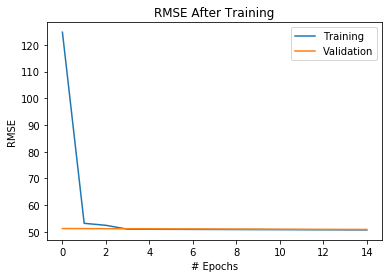

In [184]:
# plot metrics
plt.plot(history_cnn_m6.history['rmse'], label='Training')
plt.plot(history_cnn_m6.history['val_rmse'], label='Validation')
plt.xlabel("# Epochs")
plt.ylabel("RMSE")
plt.title('RMSE After Training')
plt.legend()
plt.show()

Results from Transfer Learning: Clearly there is overfitting as the parameters are more but data is less. Will retrain the model with augmented data and test.

From the above results it seems like the LeNet-5 model with 50 epochs and VGG-16 with small filters are the best models based on lowest RMSE. It's obvious that overfitting is a problem here because we have a small dataset. 

Next we will try to augment the training data and try to test performance of the above 2 best models and see where that takes us. 
